## TODOs
- OD normalization
- Empty entries
- Remove maps with low player counts
- Consider play counts

## Dependencies
- ossapi
- pytorch
- numpy
- plotly
- pandas
- chart_studio

In [1]:
from ossapi import *
import copy

In [2]:
import os
api = OssapiV2(int(os.environ['OSUAPIv2_APP_ID']), os.environ['OSUAPIv2_APP_SECRET'], os.environ['OSUAPIv2_APP_CALLBACK'])
apiv1 = Ossapi(os.environ['OSUAPIv1_KEY'])

In [3]:
import torch

def get_acc(c_300, c_100, c_miss):
    total = c_300 + c_100 + c_miss
    acc = (c_300 + 0.5 * c_100) / total
    return acc

class PlayerMapPool:
    
    def __init__(self):
        self.players = {}
        self.maps = {}
        
    def AddMap(self, bid):
        
        if repr(bid) in self.maps:
            print("Map bid=%s already exists in the dataset." % (bid))
            return
        
        affected = 0
        
        # NoMod / HD, Taiko, Top 100
        scores = apiv1.get_scores(bid, mode=1, mods=0, limit=100)
        scores += apiv1.get_scores(bid, mode=1, mods=8, limit=100) # HD
        mapdata = api.beatmap(bid)
        
        for score in scores:
            
            affect = False
            
            # New player
            if repr(score.user_id) not in self.players:
                self.players[repr(score.user_id)] = {
                    'id': score.user_id,
                    'name': score.username,
                    'maps': []
                }
                affect = True
            
            scoreObj = {
                'bid': bid,
                'accuracy': get_acc(score.count_300, score.count_100, score.count_miss),
                'p': score.count_300,
                'g': score.count_100,
                'm': score.count_miss,
                'mods': score.mods.short_name()
            }
            
            exist = False
            for i, m in enumerate(self.players[repr(score.user_id)]["maps"]):
                if m['bid'] == bid:
                    exist = True
                    if m['accuracy'] < get_acc(score.count_300, score.count_100, score.count_miss):
                        self.players[repr(score.user_id)]["maps"][i] = scoreObj
            
            if not exist:
                self.players[repr(score.user_id)]["maps"].append(scoreObj)
                affect = True
            
            if affect:
                affected += 1
        
        self.maps[repr(bid)] = mapdata
        print("Updated %d players for Map bid=%s." % (affected, bid))
        print("Currently %d players and %d maps in dataset." % (len(self.players), len(self.maps)))
        
    def Store(self, path = "dataset.pkl"):
        torch.save([self.players, self.maps], path)
        print("Dataset saved to %s with %d maps, %d players." % (path, len(self.maps), len(self.players)))
        
    def LoadFrom(self, path):
        self.players, self.maps = torch.load(path)
        print("Dataset loaded from %s with %d maps, %d players." % (path, len(self.maps), len(self.players)))
        
    def Filter(self, minimum_maps = 2):
        
        removed = []
        self.raw_players = copy.deepcopy(self.players)
        
        for player in self.players:
            if(len(self.players[player]["maps"]) < minimum_maps):
                removed.append(player)
        
        for r in removed:
            del self.players[r]
            
        print("Filtering out players with less than %d maps play records." % minimum_maps)
        print("Currently %d players and %d maps in dataset." % (len(self.players), len(self.maps)))

In [4]:
pool = PlayerMapPool()
pool.LoadFrom("dataset.pkl")

pool.AddMap(1921771) # ♡ Lie [False]
pool.AddMap(1012367) # ♡ Cross The Finish Line [Inner Oni]
pool.AddMap(1549622) # ♡ Katagiri [Katagiri]
pool.AddMap(2454551) # R LvC3 [Hell Oni]
pool.AddMap(1714380) # R Dizzolve [goheegy's Inner Oni]
pool.AddMap(2584209) # R Secret Desire [Desire]
pool.AddMap(2421238) # R Nisemono Chuuihou [Hell Oni]
pool.AddMap(777192)  # R Wizdomiot [Crazy Oni]
pool.AddMap(1559744) # R Bison Charge [Bit Crusher]
pool.AddMap(1806900) # R Thank you, FRIENDS!! [Farewell Oni]
pool.AddMap(1879405) # R Colorful [Evil]
pool.AddMap(1574488) # ♡ Hizai ni Negu [Inner Oni]
pool.AddMap(2537392) # ♡ Anoyo-iki no Bus ni Notte Saraba. (Sped Up Ver.) [Inner Oni]

biggerPool = [2861112, 2564670, 2266329, 1888472, 2266392, 2335441, 778483, 774996, 1828695, 
              2350370, 1381623, 1456720, 1442868, 1449571, 677652, 1153370, 439529, 1273614, 
              435822, 1360616, 104401]

for bid in biggerPool:
    pool.AddMap(bid)
    
pool.Store("dataset.pkl")

Dataset loaded from dataset.pkl with 2282 maps, 17383 players.
Map bid=1921771 already exists in the dataset.
Map bid=1012367 already exists in the dataset.
Map bid=1549622 already exists in the dataset.
Map bid=2454551 already exists in the dataset.
Map bid=1714380 already exists in the dataset.
Map bid=2584209 already exists in the dataset.
Map bid=2421238 already exists in the dataset.
Map bid=777192 already exists in the dataset.
Map bid=1559744 already exists in the dataset.
Map bid=1806900 already exists in the dataset.
Map bid=1879405 already exists in the dataset.
Map bid=1574488 already exists in the dataset.
Map bid=2537392 already exists in the dataset.
Map bid=2861112 already exists in the dataset.
Map bid=2564670 already exists in the dataset.
Map bid=2266329 already exists in the dataset.
Map bid=1888472 already exists in the dataset.
Map bid=2266392 already exists in the dataset.
Map bid=2335441 already exists in the dataset.
Map bid=778483 already exists in the dataset.

In [5]:
def GrabFromBP(pool, uid):
    print("Grab BP maps from uid %d (%s)" % (uid, apiv1.get_user(uid).username))
    best = apiv1.get_user_best(uid, limit = 100, mode = 1)
    for b in best:
        pool.AddMap(b.beatmap_id)

GrabFromBP(pool, 1558839)
pool.Store()

Grab BP maps from uid 1558839 (betairylia)
Map bid=2584209 already exists in the dataset.
Map bid=1315674 already exists in the dataset.
Map bid=1879405 already exists in the dataset.
Map bid=1082284 already exists in the dataset.
Map bid=1282805 already exists in the dataset.
Map bid=2112927 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=1191922 already exists in the dataset.
Map bid=2692813 already exists in the dataset.
Map bid=1273614 already exists in the dataset.
Map bid=2330207 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=2028938 already exists in the dataset.
Map bid=1150699 already exists in the dataset.
Map bid=1844171 already exists in the dataset.
Map bid=120132 already exists in the dataset.
Map bid=1843535 already exists in the dataset.
Map bid=1358048 already exists in the dataset.
Map bid=75184 already exists in the dataset.
Map bid=1360252 already exists in the dataset.
Map bid=890435 alread

In [6]:
TargetPlayers = [
    1558839, # betairylia
    11692528,# Lubei
    6764344, # Nepoch
    10324309,# Flandre sca
    8609627, # Edward
    10507557,# Hynix
    3383404, # Rin
    2221895, # Wonberman
    12208924,# OvO
    6443264, # acst
    9603470, # Yusyou
    4314222, # Kafuu Cirno
    609536,  # lzx
    
    2349769, # kk
    4315477, # sSSS
    5310623, # Blastix
    6294200, # te
    2073644, # Risona
    810813,  # HM
    6844521, # szh134
    9383908, # shoucan
    4112195, # 7j
    12480076,# Michael
    11341131,# NaNa
    8263525, # smf
    81972,   # Mic
    15917084,# Apricot L
    12703319,# Minato
    12749779,# Lilia Angel
    16903694,# Pinkiemane
    
    8741695, # syaron
    983349,  # applerss
    6170507, # yu68
    5321719, # uone
    165027,  # Peaceful
    1152851, # Bamgoe
    9912966, # Zeth
    9503098, # hoku
    9864847, # Botched
    7955738, # CL
    13302996,# Boaz
    2865172, # Bries
    11117835,# Quass
    9856910, # Gamelan
    8772103, # nuku
    7740442, # Spartric
    6632605, # Megafan
    14005209,# aquachan
    12611862,# diamond
    933630,  # fanhoho
    6498810, # Kerasi
    3867109, # Maou
    5054081, # rai
    12248285,# Storm
    10530606,# Neon
    10694200,# KD
    15541593,# Dau
    1751879, # shiroino
    11936599,# Quibby
    8770622, # ITGT
    1100246, # DefiantJ
    
    6177263, # mp kick Kasumi-sama
]

from tqdm.notebook import tqdm
for i in tqdm(range(len(TargetPlayers))):
    GrabFromBP(pool, TargetPlayers[i])

  0%|          | 0/62 [00:00<?, ?it/s]

Grab BP maps from uid 1558839 (betairylia)
Map bid=2584209 already exists in the dataset.
Map bid=1315674 already exists in the dataset.
Map bid=1879405 already exists in the dataset.
Map bid=1082284 already exists in the dataset.
Map bid=1282805 already exists in the dataset.
Map bid=2112927 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=1191922 already exists in the dataset.
Map bid=2692813 already exists in the dataset.
Map bid=1273614 already exists in the dataset.
Map bid=2330207 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=2028938 already exists in the dataset.
Map bid=1150699 already exists in the dataset.
Map bid=1844171 already exists in the dataset.
Map bid=120132 already exists in the dataset.
Map bid=1843535 already exists in the dataset.
Map bid=1358048 already exists in the dataset.
Map bid=75184 already exists in the dataset.
Map bid=1360252 already exists in the dataset.
Map bid=890435 alread

Grab BP maps from uid 6764344 (Nepoch)
Map bid=1879405 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=1358048 already exists in the dataset.
Map bid=2692813 already exists in the dataset.
Map bid=903809 already exists in the dataset.
Map bid=2607739 already exists in the dataset.
Map bid=73066 already exists in the dataset.
Map bid=2249862 already exists in the dataset.
Map bid=1360616 already exists in the dataset.
Map bid=1344856 already exists in the dataset.
Map bid=1504535 already exists in the dataset.
Map bid=1958814 already exists in the dataset.
Map bid=2718320 already exists in the dataset.
Map bid=1170442 already exists in the dataset.
Map bid=720267 already exists in the dataset.
Map bid=403323 already exists in the dataset.
Map bid=1888472 already exists in the dataset.
Map bid=1183029 already exists in the dataset.
Map bid=1969505 already exists in the dataset.
Map bid=1558422 already exi

Map bid=1315674 already exists in the dataset.
Map bid=1153788 already exists in the dataset.
Map bid=1273614 already exists in the dataset.
Map bid=1082284 already exists in the dataset.
Map bid=2725091 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=890435 already exists in the dataset.
Map bid=2872892 already exists in the dataset.
Map bid=936572 already exists in the dataset.
Map bid=1885024 already exists in the dataset.
Map bid=2391552 already exists in the dataset.
Map bid=2406373 already exists in the dataset.
Map bid=2564670 already exists in the dataset.
Map bid=903809 already exists in the dataset.
Map bid=1193146 already exists in the dataset.
Map bid=2961643 already exists in the dataset.
Map bid=3034224 already exists in the dataset.
Map bid=1282805 already exists in the dataset.
Map bid=2584209 already exists in the dataset.
Map bid=2028938 already exists in the dataset.
Map bid=2956106 a

Grab BP maps from uid 3383404 (OtakusRin)
Map bid=383455 already exists in the dataset.
Map bid=2991699 already exists in the dataset.
Map bid=2466833 already exists in the dataset.
Map bid=1082284 already exists in the dataset.
Map bid=1315674 already exists in the dataset.
Map bid=2445832 already exists in the dataset.
Map bid=1402693 already exists in the dataset.
Map bid=2584209 already exists in the dataset.
Map bid=2313837 already exists in the dataset.
Map bid=1700181 already exists in the dataset.
Map bid=1879405 already exists in the dataset.
Map bid=2112927 already exists in the dataset.
Map bid=91391 already exists in the dataset.
Map bid=1282805 already exists in the dataset.
Map bid=2601412 already exists in the dataset.
Map bid=1183029 already exists in the dataset.
Map bid=2692813 already exists in the dataset.
Map bid=2427975 already exists in the dataset.
Map bid=1129831 already exists in the dataset.
Map bid=3170171 already exists in the dataset.
Map bid=1444656 alrea

Grab BP maps from uid 12208924 (-OvO-)
Map bid=890435 already exists in the dataset.
Map bid=1000101 already exists in the dataset.
Map bid=1191922 already exists in the dataset.
Map bid=720267 already exists in the dataset.
Map bid=207134 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=866288 already exists in the dataset.
Map bid=903809 already exists in the dataset.
Map bid=1370184 already exists in the dataset.
Map bid=1170442 already exists in the dataset.
Map bid=1434384 already exists in the dataset.
Map bid=118668 already exists in the dataset.
Map bid=148307 already exists in the dataset.
Map bid=403323 already exists in the dataset.
Map bid=1176481 already exists in the dataset.
Map bid=1360616 already exists in the dataset.
Map bid=1538448 already exists in the dataset.
Map bid=1007802 already exists in the dataset.
Map bid=153886 already exists in the dataset.
Map bid=2143244 already exists in the dataset.
Map bid=157233 already exists 

Grab BP maps from uid 9603470 (Yusyou)
Map bid=1200510 already exists in the dataset.
Map bid=2029066 already exists in the dataset.
Map bid=2759819 already exists in the dataset.
Map bid=1097541 already exists in the dataset.
Map bid=2997943 already exists in the dataset.
Map bid=2569352 already exists in the dataset.
Map bid=1047870 already exists in the dataset.
Map bid=118718 already exists in the dataset.
Map bid=931556 already exists in the dataset.
Map bid=1421041 already exists in the dataset.
Map bid=1097542 already exists in the dataset.
Map bid=1736565 already exists in the dataset.
Map bid=1110481 already exists in the dataset.
Map bid=2890206 already exists in the dataset.
Map bid=2128979 already exists in the dataset.
Map bid=1153788 already exists in the dataset.
Map bid=2043924 already exists in the dataset.
Map bid=1248070 already exists in the dataset.
Map bid=2587428 already exists in the dataset.
Map bid=699733 already exists in the dataset.
Map bid=1949171 already 

Grab BP maps from uid 609536 (lzxstupid)
Map bid=1140239 already exists in the dataset.
Map bid=1594500 already exists in the dataset.
Map bid=394235 already exists in the dataset.
Map bid=1153788 already exists in the dataset.
Map bid=152857 already exists in the dataset.
Map bid=2048462 already exists in the dataset.
Map bid=2412001 already exists in the dataset.
Map bid=75360 already exists in the dataset.
Map bid=1286944 already exists in the dataset.
Map bid=1217999 already exists in the dataset.
Map bid=1097541 already exists in the dataset.
Map bid=1176481 already exists in the dataset.
Map bid=1682932 already exists in the dataset.
Map bid=263683 already exists in the dataset.
Map bid=857652 already exists in the dataset.
Map bid=342847 already exists in the dataset.
Map bid=904516 already exists in the dataset.
Map bid=1989546 already exists in the dataset.
Map bid=749758 already exists in the dataset.
Map bid=491412 already exists in the dataset.
Map bid=2131481 already exist

Map bid=1879405 already exists in the dataset.
Map bid=2112927 already exists in the dataset.
Map bid=1183029 already exists in the dataset.
Map bid=2570727 already exists in the dataset.
Map bid=2223033 already exists in the dataset.
Map bid=2022931 already exists in the dataset.
Map bid=1364659 already exists in the dataset.
Map bid=2007651 already exists in the dataset.
Map bid=2648108 already exists in the dataset.
Map bid=3024108 already exists in the dataset.
Map bid=2059692 already exists in the dataset.
Map bid=2656372 already exists in the dataset.
Map bid=2547165 already exists in the dataset.
Map bid=2321553 already exists in the dataset.
Map bid=1464530 already exists in the dataset.
Map bid=2158454 already exists in the dataset.
Map bid=2598031 already exists in the dataset.
Map bid=557818 already exists in the dataset.
Map bid=1414482 already exists in the dataset.
Map bid=2204598 already exists in the dataset.
Map bid=2494147 already exists in the dataset.
Map bid=236093

Grab BP maps from uid 6294200 (te2035)
Map bid=2158454 already exists in the dataset.
Map bid=2266075 already exists in the dataset.
Map bid=1569703 already exists in the dataset.
Map bid=2143244 already exists in the dataset.
Map bid=2267914 already exists in the dataset.
Map bid=1150699 already exists in the dataset.
Map bid=2007651 already exists in the dataset.
Map bid=1473448 already exists in the dataset.
Map bid=813300 already exists in the dataset.
Map bid=88614 already exists in the dataset.
Map bid=576979 already exists in the dataset.
Map bid=1946932 already exists in the dataset.
Map bid=1516752 already exists in the dataset.
Map bid=777192 already exists in the dataset.
Map bid=1430505 already exists in the dataset.
Map bid=1806900 already exists in the dataset.
Map bid=1029561 already exists in the dataset.
Map bid=1584721 already exists in the dataset.
Map bid=1078478 already exists in the dataset.
Map bid=889000 already exists in the dataset.
Map bid=82427 already exist

Grab BP maps from uid 810813 (HM495)
Map bid=2310254 already exists in the dataset.
Map bid=774996 already exists in the dataset.
Map bid=1379208 already exists in the dataset.
Map bid=261205 already exists in the dataset.
Map bid=121334 already exists in the dataset.
Map bid=132889 already exists in the dataset.
Map bid=92525 already exists in the dataset.
Map bid=439066 already exists in the dataset.
Map bid=800560 already exists in the dataset.
Map bid=1382019 already exists in the dataset.
Map bid=2956254 already exists in the dataset.
Map bid=155430 already exists in the dataset.
Map bid=1753070 already exists in the dataset.
Map bid=620995 already exists in the dataset.
Map bid=103282 already exists in the dataset.
Map bid=249371 already exists in the dataset.
Map bid=2239022 already exists in the dataset.
Map bid=777192 already exists in the dataset.
Map bid=153886 already exists in the dataset.
Map bid=2510404 already exists in the dataset.
Map bid=2265575 already exists in the

Grab BP maps from uid 9383908 (shoucan91)
Map bid=2202720 already exists in the dataset.
Map bid=2547165 already exists in the dataset.
Map bid=1888472 already exists in the dataset.
Map bid=1841309 already exists in the dataset.
Map bid=1806900 already exists in the dataset.
Map bid=1746892 already exists in the dataset.
Map bid=2559206 already exists in the dataset.
Map bid=2028938 already exists in the dataset.
Map bid=1418746 already exists in the dataset.
Map bid=1838986 already exists in the dataset.
Map bid=1959522 already exists in the dataset.
Map bid=195478 already exists in the dataset.
Map bid=936050 already exists in the dataset.
Map bid=1306458 already exists in the dataset.
Map bid=1531625 already exists in the dataset.
Map bid=1586976 already exists in the dataset.
Map bid=2024688 already exists in the dataset.
Map bid=2056114 already exists in the dataset.
Map bid=2037584 already exists in the dataset.
Map bid=2406373 already exists in the dataset.
Map bid=1419340 alre

Grab BP maps from uid 12480076 (Michaelonl)
Map bid=2077701 already exists in the dataset.
Map bid=2591524 already exists in the dataset.
Map bid=2679859 already exists in the dataset.
Map bid=1733315 already exists in the dataset.
Map bid=2211161 already exists in the dataset.
Map bid=261205 already exists in the dataset.
Map bid=2007761 already exists in the dataset.
Map bid=2197281 already exists in the dataset.
Map bid=2559716 already exists in the dataset.
Map bid=2357917 already exists in the dataset.
Map bid=2026430 already exists in the dataset.
Map bid=2022931 already exists in the dataset.
Map bid=2037584 already exists in the dataset.
Map bid=1858919 already exists in the dataset.
Map bid=2542872 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=2025380 already exists in the dataset.
Map bid=1923544 already exists in the dataset.
Map bid=2226451 already exists in the dataset.
Map bid=1191922 already exists in the dataset.
Map bid=1646707 a

Grab BP maps from uid 8263525 (super mario fan)
Map bid=383455 already exists in the dataset.
Map bid=1082284 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=890435 already exists in the dataset.
Map bid=1379641 already exists in the dataset.
Map bid=649044 already exists in the dataset.
Map bid=1661121 already exists in the dataset.
Map bid=132914 already exists in the dataset.
Map bid=1273614 already exists in the dataset.
Map bid=1860941 already exists in the dataset.
Map bid=1739253 already exists in the dataset.
Map bid=965244 already exists in the dataset.
Map bid=1414482 already exists in the dataset.
Map bid=2061960 already exists in the dataset.
Map bid=1282805 already exists in the dataset.
Map bid=866288 already exists in the dataset.
Map bid=903809 already exists in the dataset.
Map bid=1844171 already exists in the dataset.
Map bid=97949 already exists in the dataset.
Map bid=207134 already exists in the dataset.
Map bid=2584209 alread

Grab BP maps from uid 15917084 (Apricot L)
Map bid=2601412 already exists in the dataset.
Map bid=207134 already exists in the dataset.
Map bid=2882110 already exists in the dataset.
Map bid=2191080 already exists in the dataset.
Map bid=2029066 already exists in the dataset.
Map bid=1082284 already exists in the dataset.
Map bid=2337895 already exists in the dataset.
Map bid=2143244 already exists in the dataset.
Map bid=1170442 already exists in the dataset.
Map bid=2024241 already exists in the dataset.
Map bid=2274353 already exists in the dataset.
Map bid=866288 already exists in the dataset.
Map bid=132914 already exists in the dataset.
Map bid=1911852 already exists in the dataset.
Map bid=1097541 already exists in the dataset.
Map bid=2480909 already exists in the dataset.
Map bid=2445145 already exists in the dataset.
Map bid=2311580 already exists in the dataset.
Map bid=1936354 already exists in the dataset.
Map bid=2385259 already exists in the dataset.
Map bid=2383502 alre

Grab BP maps from uid 12749779 ([Lily_White])
Map bid=2584209 already exists in the dataset.
Map bid=1315674 already exists in the dataset.
Map bid=777192 already exists in the dataset.
Map bid=1413771 already exists in the dataset.
Map bid=2560854 already exists in the dataset.
Map bid=1281858 already exists in the dataset.
Map bid=1880273 already exists in the dataset.
Map bid=2578484 already exists in the dataset.
Map bid=781859 already exists in the dataset.
Map bid=2189542 already exists in the dataset.
Map bid=1567153 already exists in the dataset.
Map bid=1319597 already exists in the dataset.
Map bid=557818 already exists in the dataset.
Map bid=2191080 already exists in the dataset.
Map bid=1100855 already exists in the dataset.
Map bid=2798101 already exists in the dataset.
Map bid=2782426 already exists in the dataset.
Map bid=345483 already exists in the dataset.
Map bid=1847629 already exists in the dataset.
Map bid=1854298 already exists in the dataset.
Map bid=2028938 al

Grab BP maps from uid 8741695 (syaron105)
Map bid=1402693 already exists in the dataset.
Map bid=1464741 already exists in the dataset.
Map bid=690886 already exists in the dataset.
Map bid=1102046 already exists in the dataset.
Map bid=1879405 already exists in the dataset.
Map bid=2447275 already exists in the dataset.
Map bid=1302378 already exists in the dataset.
Map bid=2330487 already exists in the dataset.
Map bid=2956690 already exists in the dataset.
Map bid=2584209 already exists in the dataset.
Map bid=956273 already exists in the dataset.
Map bid=1763738 already exists in the dataset.
Map bid=1240578 already exists in the dataset.
Map bid=1280900 already exists in the dataset.
Map bid=1531625 already exists in the dataset.
Map bid=1418746 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=899716 already exists in the dataset.
Map bid=1473448 already exists in the dataset.
Map bid=2264245 already exists in the dataset.
Map bid=1828695 alread

Grab BP maps from uid 6170507 (_yu68)
Map bid=1879405 already exists in the dataset.
Map bid=831443 already exists in the dataset.
Map bid=1402693 already exists in the dataset.
Map bid=936050 already exists in the dataset.
Map bid=1418746 already exists in the dataset.
Map bid=1056236 already exists in the dataset.
Map bid=2302979 already exists in the dataset.
Map bid=683188 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=2024688 already exists in the dataset.
Map bid=1203661 already exists in the dataset.
Map bid=956273 already exists in the dataset.
Map bid=1183029 already exists in the dataset.
Map bid=935271 already exists in the dataset.
Map bid=871924 already exists in the dataset.
Map bid=1531625 already exists in the dataset.
Map bid=1280900 already exists in the dataset.
Map bid=1439299 already exists in the dataset.
Map bid=988899 already exists in the dataset.
Map bid=1082284 already exists in the dataset.
Map bid=2045278 already exists

Map bid=1879405 already exists in the dataset.
Map bid=2584209 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=1315674 already exists in the dataset.
Map bid=2991699 already exists in the dataset.
Map bid=2427975 already exists in the dataset.
Map bid=3001709 already exists in the dataset.
Map bid=3176700 already exists in the dataset.
Map bid=2865712 already exists in the dataset.
Map bid=2708053 already exists in the dataset.
Map bid=2313837 already exists in the dataset.
Map bid=1172567 already exists in the dataset.
Map bid=2012389 already exists in the dataset.
Map bid=1580327 already exists in the dataset.
Map bid=2411176 already exists in the dataset.
Map bid=1127173 already exists in the dataset.
Map bid=683188 already exists in the dataset.
Map bid=2400474 already exists in the dataset.
Map bid=1377273 already exists in the dataset.
Map bid=1639326 already exists in the dataset.
Map bid=1273614 already exists in the dataset.
Map bid=144511

Grab BP maps from uid 9912966 ([Zeth])
Map bid=2313837 already exists in the dataset.
Map bid=1183029 already exists in the dataset.
Map bid=1377273 already exists in the dataset.
Map bid=2584209 already exists in the dataset.
Map bid=2337466 already exists in the dataset.
Map bid=784586 already exists in the dataset.
Map bid=1369892 already exists in the dataset.
Map bid=2797467 already exists in the dataset.
Map bid=1504535 already exists in the dataset.
Map bid=557818 already exists in the dataset.
Map bid=2716081 already exists in the dataset.
Map bid=1399480 already exists in the dataset.
Map bid=1162312 already exists in the dataset.
Map bid=2007651 already exists in the dataset.
Map bid=1473448 already exists in the dataset.
Map bid=1204254 already exists in the dataset.
Map bid=1763967 already exists in the dataset.
Map bid=2686694 already exists in the dataset.
Map bid=1202226 already exists in the dataset.
Map bid=2321553 already exists in the dataset.
Map bid=2287337 already

Grab BP maps from uid 9864847 (B0tch3d)
Map bid=2767111 already exists in the dataset.
Map bid=1531625 already exists in the dataset.
Map bid=1879405 already exists in the dataset.
Map bid=1309324 already exists in the dataset.
Map bid=2026430 already exists in the dataset.
Map bid=683991 already exists in the dataset.
Map bid=2584209 already exists in the dataset.
Map bid=103282 already exists in the dataset.
Map bid=1288323 already exists in the dataset.
Map bid=3001709 already exists in the dataset.
Map bid=2559206 already exists in the dataset.
Map bid=777192 already exists in the dataset.
Map bid=1315674 already exists in the dataset.
Map bid=1000101 already exists in the dataset.
Map bid=899716 already exists in the dataset.
Map bid=935271 already exists in the dataset.
Map bid=2427975 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=1240578 already exists in the dataset.
Map bid=1760698 already exists in the dataset.
Map bid=2466833 already ex

Map bid=2202720 already exists in the dataset.
Map bid=1280900 already exists in the dataset.
Map bid=1879405 already exists in the dataset.
Map bid=1531625 already exists in the dataset.
Map bid=1418746 already exists in the dataset.
Map bid=2649335 already exists in the dataset.
Map bid=1747526 already exists in the dataset.
Map bid=1402693 already exists in the dataset.
Map bid=2865712 already exists in the dataset.
Map bid=3047272 already exists in the dataset.
Map bid=2067808 already exists in the dataset.
Map bid=1806900 already exists in the dataset.
Map bid=2332095 already exists in the dataset.
Map bid=936050 already exists in the dataset.
Map bid=1711554 already exists in the dataset.
Map bid=3163541 already exists in the dataset.
Map bid=2872892 already exists in the dataset.
Map bid=640739 already exists in the dataset.
Map bid=991176 already exists in the dataset.
Map bid=1306458 already exists in the dataset.
Map bid=2024688 already exists in the dataset.
Map bid=1913440 

Grab BP maps from uid 11117835 (QuassBot)
Map bid=3163541 already exists in the dataset.
Map bid=2391552 already exists in the dataset.
Map bid=1399480 already exists in the dataset.
Map bid=1150699 already exists in the dataset.
Map bid=2029066 already exists in the dataset.
Map bid=2767111 already exists in the dataset.
Map bid=366293 already exists in the dataset.
Map bid=1984759 already exists in the dataset.
Map bid=1559744 already exists in the dataset.
Map bid=1286944 already exists in the dataset.
Map bid=2584209 already exists in the dataset.
Map bid=1879405 already exists in the dataset.
Map bid=2513185 already exists in the dataset.
Map bid=2569352 already exists in the dataset.
Map bid=2332095 already exists in the dataset.
Map bid=439066 already exists in the dataset.
Map bid=250579 already exists in the dataset.
Map bid=899485 already exists in the dataset.
Map bid=727903 already exists in the dataset.
Map bid=64577 already exists in the dataset.
Map bid=1763967 already e

Grab BP maps from uid 8772103 (nuku0315)
Map bid=2391552 already exists in the dataset.
Map bid=444356 already exists in the dataset.
Map bid=879623 already exists in the dataset.
Map bid=1468970 already exists in the dataset.
Map bid=1183029 already exists in the dataset.
Map bid=809469 already exists in the dataset.
Map bid=2674204 already exists in the dataset.
Map bid=1172819 already exists in the dataset.
Map bid=991014 already exists in the dataset.
Map bid=656534 already exists in the dataset.
Map bid=1735471 already exists in the dataset.
Map bid=45895 already exists in the dataset.
Map bid=1315674 already exists in the dataset.
Map bid=1150882 already exists in the dataset.
Map bid=970048 already exists in the dataset.
Map bid=1451282 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=974662 already exists in the dataset.
Map bid=1990449 already exists in the dataset.
Map bid=1281016 already exists in the dataset.
Map bid=718156 already exists

Grab BP maps from uid 6632605 (Megafan)
Map bid=2267070 already exists in the dataset.
Map bid=1419340 already exists in the dataset.
Map bid=1370184 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=2337466 already exists in the dataset.
Map bid=1354992 already exists in the dataset.
Map bid=2865712 already exists in the dataset.
Map bid=1285226 already exists in the dataset.
Map bid=1413771 already exists in the dataset.
Map bid=1939863 already exists in the dataset.
Map bid=1082284 already exists in the dataset.
Map bid=936572 already exists in the dataset.
Map bid=2708053 already exists in the dataset.
Map bid=2887301 already exists in the dataset.
Map bid=2810861 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=2547552 already exists in the dataset.
Map bid=2287337 already exists in the dataset.
Map bid=2090721 already exists in the dataset.
Map bid=2872892 already exists in the dataset.
Map bid=2531793 alread

Grab BP maps from uid 12611862 (ItsDiamond)
Map bid=1739253 already exists in the dataset.
Map bid=1097541 already exists in the dataset.
Map bid=774996 already exists in the dataset.
Map bid=2391552 already exists in the dataset.
Map bid=1879405 already exists in the dataset.
Map bid=2725174 already exists in the dataset.
Map bid=2081148 already exists in the dataset.
Map bid=1838986 already exists in the dataset.
Map bid=2202720 already exists in the dataset.
Map bid=161274 already exists in the dataset.
Map bid=2024688 already exists in the dataset.
Map bid=2230907 already exists in the dataset.
Map bid=2318034 already exists in the dataset.
Map bid=261205 already exists in the dataset.
Map bid=1746892 already exists in the dataset.
Map bid=994817 already exists in the dataset.
Map bid=1286944 already exists in the dataset.
Map bid=2360933 already exists in the dataset.
Map bid=2335441 already exists in the dataset.
Map bid=1411445 already exists in the dataset.
Map bid=2421236 alre

Grab BP maps from uid 6498810 (Kerasi)
Map bid=1444656 already exists in the dataset.
Map bid=1369892 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=1344856 already exists in the dataset.
Map bid=1170442 already exists in the dataset.
Map bid=965244 already exists in the dataset.
Map bid=2112927 already exists in the dataset.
Map bid=1358048 already exists in the dataset.
Map bid=2686694 already exists in the dataset.
Map bid=720267 already exists in the dataset.
Map bid=1504535 already exists in the dataset.
Map bid=2601412 already exists in the dataset.
Map bid=2337466 already exists in the dataset.
Map bid=835691 already exists in the dataset.
Map bid=127115 already exists in the dataset.
Map bid=2012389 already exists in the dataset.
Map bid=2400474 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=1860941 already exists in the dataset.
Map bid=2029066 already exists in the dataset.
Map bid=1460904 already ex

Grab BP maps from uid 5054081 (RaiRator)
Map bid=1559744 already exists in the dataset.
Map bid=2191080 already exists in the dataset.
Map bid=1753070 already exists in the dataset.
Map bid=2573450 already exists in the dataset.
Map bid=818554 already exists in the dataset.
Map bid=2122025 already exists in the dataset.
Map bid=2410300 already exists in the dataset.
Map bid=1747624 already exists in the dataset.
Map bid=2984048 already exists in the dataset.
Map bid=890435 already exists in the dataset.
Map bid=1243907 already exists in the dataset.
Map bid=1344250 already exists in the dataset.
Map bid=1550322 already exists in the dataset.
Map bid=1714380 already exists in the dataset.
Map bid=1278441 already exists in the dataset.
Map bid=2785956 already exists in the dataset.
Map bid=1148996 already exists in the dataset.
Map bid=1426536 already exists in the dataset.
Map bid=1404088 already exists in the dataset.
Map bid=1956277 already exists in the dataset.
Map bid=1176481 alrea

Grab BP maps from uid 10530606 ([-Neon-])
Map bid=1879405 already exists in the dataset.
Map bid=2584209 already exists in the dataset.
Map bid=1315674 already exists in the dataset.
Map bid=1082284 already exists in the dataset.
Map bid=1913440 already exists in the dataset.
Map bid=1828695 already exists in the dataset.
Map bid=2810861 already exists in the dataset.
Map bid=1282805 already exists in the dataset.
Map bid=2961632 already exists in the dataset.
Map bid=1273614 already exists in the dataset.
Map bid=1183029 already exists in the dataset.
Map bid=795198 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=207134 already exists in the dataset.
Map bid=127115 already exists in the dataset.
Map bid=781876 already exists in the dataset.
Map bid=116000 already exists in the dataset.
Map bid=661517 already exists in the dataset.
Map bid=1444656 already exists in the dataset.
Map bid=1170442 already exists in the dataset.
Map bid=2629418 already e

Grab BP maps from uid 15541593 (Dau)
Map bid=1828695 already exists in the dataset.
Map bid=383455 already exists in the dataset.
Map bid=2882110 already exists in the dataset.
Map bid=1864382 already exists in the dataset.
Map bid=1913440 already exists in the dataset.
Map bid=72404 already exists in the dataset.
Map bid=1282805 already exists in the dataset.
Map bid=1082284 already exists in the dataset.
Map bid=2130201 already exists in the dataset.
Map bid=2267070 already exists in the dataset.
Map bid=2887301 already exists in the dataset.
Map bid=2686694 already exists in the dataset.
Map bid=1207233 already exists in the dataset.
Map bid=2584974 already exists in the dataset.
Map bid=2689990 already exists in the dataset.
Map bid=1369892 already exists in the dataset.
Map bid=1274287 already exists in the dataset.
Map bid=2262482 already exists in the dataset.
Map bid=435822 already exists in the dataset.
Map bid=2429042 already exists in the dataset.
Map bid=2252523 already exi

Grab BP maps from uid 11936599 (Quibby)
Map bid=2421238 already exists in the dataset.
Map bid=2391552 already exists in the dataset.
Map bid=1526268 already exists in the dataset.
Map bid=1858919 already exists in the dataset.
Map bid=1193146 already exists in the dataset.
Map bid=936050 already exists in the dataset.
Map bid=1913440 already exists in the dataset.
Map bid=1344856 already exists in the dataset.
Map bid=2599830 already exists in the dataset.
Map bid=793432 already exists in the dataset.
Map bid=1946932 already exists in the dataset.
Map bid=1465000 already exists in the dataset.
Map bid=313793 already exists in the dataset.
Map bid=2135941 already exists in the dataset.
Map bid=1399348 already exists in the dataset.
Map bid=2266075 already exists in the dataset.
Map bid=1418746 already exists in the dataset.
Map bid=890435 already exists in the dataset.
Map bid=1466716 already exists in the dataset.
Map bid=1558422 already exists in the dataset.
Map bid=724040 already e

Grab BP maps from uid 1100246 (DefiantJ)
Map bid=78034 already exists in the dataset.
Map bid=617859 already exists in the dataset.
Map bid=2545664 already exists in the dataset.
Map bid=2081704 already exists in the dataset.
Map bid=2293612 already exists in the dataset.
Map bid=76993 already exists in the dataset.
Map bid=2121091 already exists in the dataset.
Map bid=76245 already exists in the dataset.
Map bid=406756 already exists in the dataset.
Map bid=360692 already exists in the dataset.
Map bid=2199061 already exists in the dataset.
Map bid=2532774 already exists in the dataset.
Map bid=1274406 already exists in the dataset.
Map bid=2706169 already exists in the dataset.
Map bid=46299 already exists in the dataset.
Map bid=46300 already exists in the dataset.
Map bid=1607054 already exists in the dataset.
Map bid=2982534 already exists in the dataset.
Map bid=2355101 already exists in the dataset.
Map bid=2410956 already exists in the dataset.
Map bid=2275497 already exists i

In [7]:
# Should be 17383 Players and 2282 maps
pool.Store()

Dataset saved to dataset.pkl with 2282 maps, 17383 players.


In [8]:
pool = PlayerMapPool()
pool.LoadFrom("dataset.pkl")
pool.Filter(8)

Dataset loaded from dataset.pkl with 2282 maps, 17383 players.
Filtering out players with less than 8 maps play records.
Currently 4697 players and 2282 maps in dataset.


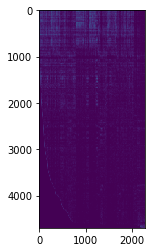

In [9]:
# Build matrix
import numpy as np

accuracy = np.zeros((len(pool.players), len(pool.maps)))
ps = np.zeros((len(pool.players), len(pool.maps)))
gs = np.zeros((len(pool.players), len(pool.maps)))
ms = np.zeros((len(pool.players), len(pool.maps)))

players_list = []
maps_list = []
maps_inv = {}

for (bid, mapData) in pool.maps.items():
    
    maps_list.append(mapData)
    maps_inv[bid] = len(maps_inv)
    
for (uid, player) in pool.players.items():
    
    for record in player["maps"]:
        accuracy[len(players_list), maps_inv[repr(record["bid"])]] = record["accuracy"]
        ps[len(players_list), maps_inv[repr(record["bid"])]] = record["p"]
        gs[len(players_list), maps_inv[repr(record["bid"])]] = record["g"]
        ms[len(players_list), maps_inv[repr(record["bid"])]] = record["m"]
    
    players_list.append(player)

from matplotlib import pyplot as plt
plt.imshow(accuracy)

In [10]:
for player in players_list:
    print("%s" % player['name'])

CreepyDuck
Lze
yassu-
POCARI SWEAT
1rori
HimekuriR18
fujisam
Ghost_r
Roger
zkane2
HEKUSODASU
owatanimal
Nekomusya7563
jyake
shoucan91
yea
JDrago14
Enko_chan
imotoniku
Xin Leviathan
Fantazy
john571
hiyokokko
HarryAda
aosoki
sigu_samidare
komasy
Acky_chinolover
kur4yam1
Six b0xes
Whulf
vodnanen
solros1101
wen294
9_9
Liz7
paction
Reu70
ChurroChef
apfhd9898
Mikalodo
Maimaing
apaajaboleh10
elahen800
Senju-Muramasa
xpokn
Jonah
Salimen
namaniku
kalmlpv
Vanity8
Dynutka
LiLy1735
wajosong
KZYS
Niro-
noct-arcadia
D o t
Articlle
kamakuraikusa
yy121011
Ozu
kaisendon
KMYK_
kakeru2315
suyuyu
N-2yn
Masque
butter0414
Rabar0209
Naninub
C-light
Das
-Dusk
-Akitai-
Noyk_n
Genjuro
SilverTyrantX
Vulkin
miki308
Pare
baluxi4572
Faputa
Shamirin_mzk
dihidi
autumndayo
VestaraKhai48
kie
Mizuan-8x
Otaku9801
lukitsa124
Cosmic Corsair
Glipe
Eyenine
sakakuxx
ilv_Rem
Svidya
Rimazii
woog
_Rise
HiroK
iloveyou4ever
phosphene47
chayleaf
tzechi
Nozdormu
Cure
Minekuchi
L1ght
Servatory
hornedlove
XOlifreX
Lno
driodx
CrowWhite

Tuhlya
HaoDai1213
NArisutora
-Evi
Dirty Doodler
aneyaru
ScoobTheHusky
Relatix
okayusan
Fyll-nds
-Owen-
ggiana
VeggieBun
pantryboy
Monkey Sly
kim7877
ChunChun04
Karri
nnmmj
Ak1nora
[-mel-]
crow7521
yurishe
Youmow
coffeelimon28
foxx0810
HEATRANGUY
PepeTheShrek
Thonis
ShinyaPoyo
weedahan
[ Reiko ]
KatieKat
bethoeny
thezaxis
Senko-san
-MagS-
StarMaidenShip
[Oriko]
Constanzeee
realmaleer
alion02
demonking7447
Dahyunni
kriles
kuzupn
surume yotyan
ukisama
Broder
SethLJ
Mavis_
boku-seishun
alvinwong1109
akiton1212
AxelHino
Karistar
MorAnyAns
duck_duck
Flandre_Vampir
QBB LSW
diamdiam
Kesuka
disc0227
Cen Yu Hong
Trag1k
Heam
starrynte
keyrinn
Staying_Silent
inazumasyo
-Rain-
TiC-
mgr1580
Fall Rain
NormalChief
Renka
LanXer JZ
kobari430
Tony G
tamutamu
ChiiChan1023
Apollon the Red
OYuuO
Nez718
Fifth Maiden
keno492
NBEkiE
Vasko2o
Naryuga
ai7haru2sh
a9040901
Izumi__Konata
Gixi_old
AyaS2461
Asan
popdoll
wisper0801
Nutnon
wht88818
minicasu
Titio08
Dusalty
Lefo
somebody_33
Astibax
hyun1
SweetBloodyLove


Likelihood is calculated in the sense that when Skill == Star, the expected outcome is 98.50% acc FC.
Two parameters: q => prob. for missing; p => prob. for 100s when not missing.
thus expected % of outcomes are - 300s (1-p)(1-q); 100s p(1-q); miss q

Exact binomial distributions are used for calculation.
<!-- Poisson distribution is used to calculate the likelihood as an approximation to binomials. -->

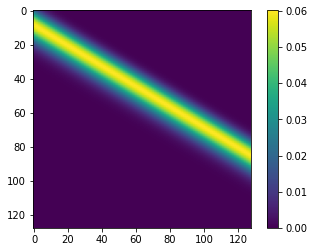

In [11]:
# I gave up so just gradient descent LUL
import torch

'''
torch source
def log_prob(self, value):
    if self._validate_args:
        self._validate_sample(value)
    log_factorial_n = torch.lgamma(self.total_count + 1)
    log_factorial_k = torch.lgamma(value + 1)
    log_factorial_nmk = torch.lgamma(self.total_count - value + 1)
    # k * log(p) + (n - k) * log(1 - p) = k * (log(p) - log(1 - p)) + n * log(1 - p)
    #     (case logit < 0)              = k * logit - n * log1p(e^logit)
    #     (case logit > 0)              = k * logit - n * (log(p) - log(1 - p)) + n * log(p)
    #                                   = k * logit - n * logit - n * log1p(e^-logit)
    #     (merge two cases)             = k * logit - n * max(logit, 0) - n * log1p(e^-|logit|)
    normalize_term = (self.total_count * _clamp_by_zero(self.logits)
                      + self.total_count * torch.log1p(torch.exp(-torch.abs(self.logits)))
                      - log_factorial_n)
    return value * self.logits - log_factorial_k - log_factorial_nmk - normalize_term
'''

import math

def _clamp_by_zero(x):
    # works like clamp(x, min=0) but has grad at 0 is 0.5
    return (x.clamp(min=0) + x - x.clamp(max=0)) / 2

# N    [       1, Nmaps]
# K    [Nplayers, Nmaps]
# logP [Nplayers, Nmaps]
def log_prob_binomial(N, K, logP):
    
    log_factorial_n = torch.lgamma(N + 1)
    log_factorial_k = torch.lgamma(K + 1)
    log_factorial_nmk = torch.lgamma(N - K + 1)
    
    normalize_term = (N * _clamp_by_zero(logP)
                      + N * torch.log1p(torch.exp(-torch.abs(logP)))
                      - log_factorial_n)
    
    return K * logP - log_factorial_k - log_factorial_nmk - normalize_term

# Log-Likelihood calculation
# TODO: Sparse optimization
def nll(skills, stars, notes, perfects, goods, misses, temp = 0.0):
    
    skills = skills.view(-1, 1)
    stars = stars.view(1, -1)
    
    signed_dist = stars - skills
    
    # 星数每比玩家强度高0.33, 玩家miss的概率就翻倍
    # 两者相等时miss率 = 0.001 (1000cb 1miss)
    logQ = math.log(0.001) + signed_dist * (1 / 0.333) * math.log(2.0)
    
    # 星数每比玩家强度高0.66, 玩家爆可的概率就翻倍
    # 两者相等时可率 = 0.02 (99% acc)
    logP = math.log(0.02) + signed_dist * (1 / 0.667) * math.log(2.0)
    
    # Misses
    miss_ll = log_prob_binomial(notes.unsqueeze(0), misses, logQ)
    
    # 100s
    good_ll = log_prob_binomial(notes.unsqueeze(0) - misses, goods, logP)
    
    # Total prob = product of misses and 100s (sum of their logarithms)
    nll = - good_ll - miss_ll
    
    return nll # [Nplayers, Nmaps]
    
# TODO: What is this visualization ...
test_skills = torch.linspace(5, 10, steps = 128)
test_stars = torch.linspace(5, 8, steps = 128)
preview = nll(test_skills, test_stars, torch.LongTensor([1000]), torch.LongTensor([985]), torch.LongTensor([15]), torch.LongTensor([0])) # 99.5% FC

# print(preview)

plt.imshow(torch.exp(-preview))
plt.colorbar()

In [12]:
# Fit the model

############## Initialzation

# Main matrix - accuracy
# M = torch.FloatTensor(accuracy)
P = torch.LongTensor(ps)
G = torch.LongTensor(gs)
M = torch.LongTensor(ms)

stars = np.asarray([i.difficulty_rating for i in maps_list])
avg_stars = stars.mean()

# Marginals
skills = torch.FloatTensor(np.random.normal(size = (len(pool.players),)) * 0.1 + avg_stars).requires_grad_() # Player skills
stars  = torch.FloatTensor(stars).requires_grad_() # Map stars
notes  = torch.LongTensor(np.asarray([i.max_combo for i in maps_list])) # Map max combo

_sk = skills

print(skills)
print(stars)

vis_steps = 100

# GPU GO
if True:
    
    device = torch.device('cuda:0')
    
    P = P.to(device)
    G = G.to(device)
    M = M.to(device)
    skills = skills.to(device).detach().requires_grad_()
    stars = stars.to(device).detach().requires_grad_()
    notes = notes.to(device)

# Optimizers
# optim_skills = torch.optim.SGD([skills], lr = 0.001, momentum = 0.9)
optim_skills = torch.optim.Adam([skills], lr = 0.001)
optim_stars = torch.optim.Adam([stars], lr = 0.001)
    
############## Iteration

# Initial value for skills (test)
for it in range(5000):
    
    total_nll = nll(skills, stars, notes, P, G, M)
    
    mean_nll = torch.masked_select(total_nll, (P > 0)).mean()
#     mean_nll = total_nll.mean()
#     mean_nll = skills.mean()
    
    optim_skills.zero_grad()
    mean_nll.backward()
#     print(_sk.grad.max())
    optim_skills.step()
    
    if it % vis_steps == 0:
        print("It %4d | %f" % (it, mean_nll))
        
# Alternating
alter_step = 250
for alter_it in range(10000):
    
    total_nll = nll(skills, stars, notes, P, G, M)
    
    mean_nll = torch.masked_select(total_nll, (P > 0)).mean()
    
    optim_skills.zero_grad()
    optim_stars.zero_grad()
    
    mean_nll.backward()
    
    if (alter_it // alter_step) % 2 == 0:
        optim_skills.step()
    else:
        optim_stars.step()
    
    if alter_it % vis_steps == 0:
        print("It %4d | %f" % (alter_it, mean_nll))

print(skills)

tensor([5.5157, 5.4074, 5.4205,  ..., 5.4549, 5.3698, 5.2535],
       requires_grad=True)
tensor([6.2200, 6.7700, 7.4200,  ..., 1.9400, 2.2500, 2.4000],
       requires_grad=True)
It    0 | 57.137680
It  100 | 51.169041
It  200 | 46.428131
It  300 | 42.609276
It  400 | 39.495152
It  500 | 36.930542
It  600 | 34.801399
It  700 | 33.022293
It  800 | 31.528105
It  900 | 30.268368
It 1000 | 29.203344
It 1100 | 28.301254
It 1200 | 27.536345
It 1300 | 26.887474
It 1400 | 26.337091
It 1500 | 25.870512
It 1600 | 25.475336
It 1700 | 25.141014
It 1800 | 24.858541
It 1900 | 24.620195
It 2000 | 24.419350
It 2100 | 24.250319
It 2200 | 24.108221
It 2300 | 23.988886
It 2400 | 23.888731
It 2500 | 23.804703
It 2600 | 23.734200
It 2700 | 23.675001
It 2800 | 23.625227
It 2900 | 23.583298
It 3000 | 23.547876
It 3100 | 23.517853
It 3200 | 23.492310
It 3300 | 23.470493
It 3400 | 23.451782
It 3500 | 23.435673
It 3600 | 23.421759
It 3700 | 23.409693
It 3800 | 23.399218
It 3900 | 23.390091
It 4000 | 23.382135


In [15]:
rank = np.argsort(skills.cpu().detach().numpy())[::-1]
for r, ix in enumerate(rank):
    print("#%3d %18s %f" % (r + 1, players_list[ix]['name'], skills[ix]))

#  1            Osumura 11.751868
#  2           hyoppola 11.661772
#  3               Deli 10.627964
#  4              Renka 10.519386
#  5            m i l 9 10.437700
#  6       lll-Sion-lll 10.400071
#  7         MjIsMaster 10.387979
#  8         kevin3333g 10.372060
#  9             Marofy 10.291868
# 10            ganshie 10.262921
# 11           FuyukiTK 10.095936
# 12    ForbiddenGarden 10.031741
# 13             Lefty3 10.027514
# 14           Hori_159 9.985921
# 15            Saikoro 9.562099
# 16            huepike 9.478707
# 17             Surres 9.388798
# 18            sing216 9.306050
# 19      icecoldsnacks 9.010567
# 20          Demiglace 8.939201
# 21          popo3_old 8.928285
# 22            asgardv 8.927402
# 23             geston 8.593408
# 24              v2fax 8.439956
# 25       OFC_youngdow 8.430797
# 26             auopes 8.410979
# 27         ROKNCTF151 8.361348
# 28             kuroru 8.351149
# 29           sB_blue_ 8.163607
# 30              Conor 8.1581

#1850           Rayhdesu 5.600299
#1851           kokoa410 5.599436
#1852              ZYuan 5.599410
#1853             Tony G 5.599280
#1854           kisitesu 5.598992
#1855           Wolfgang 5.598400
#1856          mizki6978 5.597316
#1857         Karoshi_tv 5.597117
#1858          JessiChan 5.596417
#1859          duck_duck 5.596392
#1860          kaisendon 5.596282
#1861        pyonkiti325 5.595665
#1862       GamerMetal15 5.595405
#1863             FM_298 5.595393
#1864     - Yuuka Niya - 5.595369
#1865            moosepi 5.595193
#1866         ikakun1234 5.594915
#1867          FlyTooFar 5.594227
#1868             Carlos 5.593694
#1869               Kuro 5.592161
#1870             Chatie 5.591752
#1871       VictoryGorre 5.591199
#1872           IControl 5.591116
#1873           -Akitai- 5.590661
#1874           kur4yam1 5.590660
#1875       pancake_hosi 5.590265
#1876            Spinity 5.590261
#1877     takasaki_kalma 5.589782
#1878        tonybobopig 5.588734
#1879         

#4075            Lienara 4.604134
#4076     AriPhoenixGirl 4.602816
#4077            Ryouka- 4.602648
#4078       cyupa kabura 4.602380
#4079           lina1523 4.602001
#4080        BidenGaming 4.601827
#4081             Leeafa 4.600963
#4082             sigaer 4.600307
#4083            Mikurio 4.600064
#4084           Jp-Tiger 4.599777
#4085        AppleWuIsMe 4.599418
#4086           xman2807 4.598637
#4087         EX Snorlax 4.596919
#4088              inito 4.595886
#4089            Dolphin 4.595793
#4090        Kaho-Hinata 4.595699
#4091        DrakeSauce2 4.595399
#4092         Alicia0409 4.595367
#4093      ValentinLight 4.595323
#4094          YakumoRan 4.595171
#4095        Constanzeee 4.594481
#4096            Infecta 4.594286
#4097         GodEater7x 4.593702
#4098     astolfo on osu 4.592421
#4099       Puppyluv1728 4.591893
#4100            VekArch 4.591780
#4101     sashiko-dorian 4.591244
#4102    ITotallyGetThat 4.590203
#4103            Nyahnny 4.588468
#4104         

In [16]:
xs = []
ys = []
ms = []

_s = stars.detach().cpu().numpy()

maprank = np.argsort(stars.cpu().detach().numpy())[::-1]
print("%120s | %8s <= Old SR" % ("Beatmap", "New"))
for r, ix in enumerate(maprank):
    bmap = maps_list[ix]
    mapName = "%s - %s [%s]" % (bmap.beatmapset.artist, bmap.beatmapset.title, bmap.version)
    print("%120s | %8.2f <= %4.2f" % (mapName, _s[ix], bmap.difficulty_rating))
    
    xs.append(float(bmap.difficulty_rating))
    ys.append(_s[ix])
    ms.append(bmap)

                                                                                                                 Beatmap |      New <= Old SR
                                                                                     Kobaryo - New Game Plus [Game Over] |     8.46 <= 8.71
                                                                                       Kurokotei - Scattered Faith [Oni] |     8.01 <= 8.74
                                                                                           Filthy - Comfort BLAST [BOOM] |     7.92 <= 8.31
                                                                   Lulickma - Thank You for Calling! [agu's Dial-Up Oni] |     7.92 <= 8.52
                                                                                       Laur - Terminal Missa [Missa Oni] |     7.89 <= 8.29
                                                                      Kobaryo - Necrophagiatoast [Destructive Nightmare] |     7.81 <= 8.64
                  

In [24]:
# plotly
import plotly.express as px
import pandas as pd

data = {
    'Old SR': xs, 
    'New diff': ys, 
    'Name': ["%s - %s [%s]" % (m.beatmapset.artist, m.beatmapset.title, m.version) for m in ms],
    'OD': [m.accuracy for m in ms],
    'totalPC': [m.playcount for m in ms],
}
df = pd.DataFrame(data)

fig = px.scatter(df, x = 'Old SR', y = 'New diff', hover_data = ['Name', 'Old SR', 'totalPC', 'OD', 'New diff'])
fig.show()

In [20]:
# Make public
# import chart_studio.plotly as py
# py.plot(fig, filename = 'SR^2 Expr1', auto_open=True)

'https://plotly.com/~betairya/5/'